#Задание
**Цель:**  
применить на практике базовые ансамблевые методы.  
**Описание задания:**  
В домашнем задании нужно решить задачу классификации наличия болезни сердца у пациентов. Данные для обучения моделей необходимо загрузить самостоятельно с [сайта](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction). Целевая переменная – наличие болезни сердца (HeartDisease), принимает значения 0 или 1 в зависимости от отсутствия или наличия болезни соответственно. (Подробнее о признаках можно прочесть в описании датасета на сайте. Для выполнения работы не обязательно вникать в медицинские показатели.)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

### 1.Получение данных

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/feml_data/heart.csv')
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


### 2.Подготовьте датасет к обучению моделей.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


#### a) Категориальные переменные переведите в цифровые значения. Можно использовать pd.get_dummies, preprocessing.LabelEncoder. Старайтесь не использовать для этой задачи циклы.

проверка какие значения находятся в строковых столбцах:

In [ ]:
data['Sex'].unique()

array(['M', 'F'], dtype=object)

In [ ]:
data['ChestPainType'].unique()

array(['ATA', 'NAP', 'ASY', 'TA'], dtype=object)

In [ ]:
data['RestingECG'].unique()

array(['Normal', 'ST', 'LVH'], dtype=object)

In [ ]:
data['ExerciseAngina'].unique()

array(['N', 'Y'], dtype=object)

In [ ]:
data['ST_Slope'].unique()

array(['Up', 'Flat', 'Down'], dtype=object)

кодирование категориальных столбцов:

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
data['Sex'] = le.fit(data['Sex']).transform(data['Sex'])

In [ ]:
data['ChestPainType'] = le.fit(data['ChestPainType']).transform(data['ChestPainType'])

In [ ]:
data['RestingECG'] = le.fit(data['RestingECG']).transform(data['RestingECG'])

In [ ]:
data['ExerciseAngina'] = le.fit(data['ExerciseAngina']).transform(data['ExerciseAngina'])

In [ ]:
data['ST_Slope'] = le.fit(data['ST_Slope']).transform(data['ST_Slope'])

Поработаем со столбцом Age, в датасете минимальный возраст 28, максимальный - 77

In [ ]:
print(data['Age'].min())
print(data['Age'].max())
print(data['Age'].unique())

28
77
[40 49 37 48 54 39 45 58 42 38 43 60 36 44 53 52 51 56 41 32 65 35 59 50
 47 31 46 57 55 63 66 34 33 61 29 62 28 30 74 68 72 64 69 67 73 70 77 75
 76 71]


In [ ]:
# Признак Age преобразуем в категории, если возраст от 0 до 39 - young, 40-59 - adult, 60 - 100 - пожилой (elderly)
# функция создает новый столбец с категориями Age_cat (young, adult, elderly)
def age_category(row):
    if  (row['Age'] > 0) & (row['Age'] < 40):
        row['Age_cat'] = 'young'
    elif (row['Age'] > 39) and row['Age'] < 60:
        row['Age_cat'] = 'adult'
    elif row['Age'] > 59 and row['Age'] < 100:
        row['Age_cat'] = 'elderly'
    else: row['Age_cat']  = 100
    return row

In [ ]:
data = data.apply(age_category, axis = 1)
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Age_cat
0,40.0,1.0,1.0,140.0,289.0,0.0,1.0,172.0,0.0,0.0,2.0,0.0,adult
1,49.0,0.0,2.0,160.0,180.0,0.0,1.0,156.0,0.0,1.0,1.0,1.0,adult
2,37.0,1.0,1.0,130.0,283.0,0.0,2.0,98.0,0.0,0.0,2.0,0.0,young
3,48.0,0.0,0.0,138.0,214.0,0.0,1.0,108.0,1.0,1.5,1.0,1.0,adult
4,54.0,1.0,2.0,150.0,195.0,0.0,1.0,122.0,0.0,0.0,2.0,0.0,adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45.0,1.0,3.0,110.0,264.0,0.0,1.0,132.0,0.0,1.2,1.0,1.0,adult
914,68.0,1.0,0.0,144.0,193.0,1.0,1.0,141.0,0.0,3.4,1.0,1.0,elderly
915,57.0,1.0,0.0,130.0,131.0,0.0,1.0,115.0,1.0,1.2,1.0,1.0,adult
916,57.0,0.0,1.0,130.0,236.0,0.0,0.0,174.0,0.0,0.0,1.0,1.0,adult


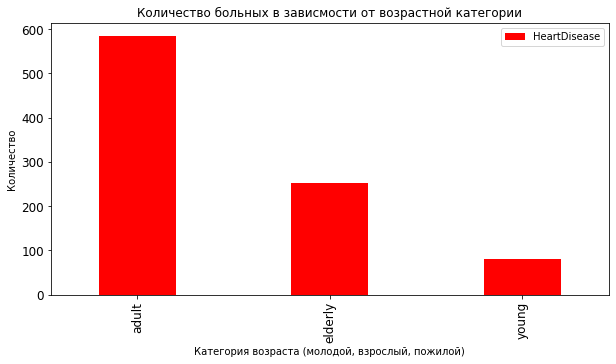

In [ ]:
data.filter(items = ['HeartDisease', 'Age_cat']).groupby(['Age_cat']).count().sort_values(by = 'HeartDisease', ascending=False).plot(kind='bar', width=0.4, figsize=(10,5), color = 'red', fontsize = 12,
                     title='Количество больных в зависмости от возрастной категории',
                     xlabel='Категория возраста (молодой, взрослый, пожилой)',
                     ylabel='Количество')

удаляем столбeц Age и кодируем столбец Age_cat

In [ ]:
data = data.drop(columns = ['Age'])

In [ ]:
data = pd.get_dummies (data, columns = ['Age_cat'])
data

,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Age_cat_adult,Age_cat_elderly,Age_cat_young
0,1.0,1.0,140.0,289.0,0.0,1.0,172.0,0.0,0.0,2.0,0.0,1,0,0
1,0.0,2.0,160.0,180.0,0.0,1.0,156.0,0.0,1.0,1.0,1.0,1,0,0
2,1.0,1.0,130.0,283.0,0.0,2.0,98.0,0.0,0.0,2.0,0.0,0,0,1
3,0.0,0.0,138.0,214.0,0.0,1.0,108.0,1.0,1.5,1.0,1.0,1,0,0
4,1.0,2.0,150.0,195.0,0.0,1.0,122.0,0.0,0.0,2.0,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,1.0,3.0,110.0,264.0,0.0,1.0,132.0,0.0,1.2,1.0,1.0,1,0,0
914,1.0,0.0,144.0,193.0,1.0,1.0,141.0,0.0,3.4,1.0,1.0,0,1,0
915,1.0,0.0,130.0,131.0,0.0,1.0,115.0,1.0,1.2,1.0,1.0,1,0,0
916,0.0,1.0,130.0,236.0,0.0,0.0,174.0,0.0,0.0,1.0,1.0,1,0,0



#### b) *Постройте 1-2 графика на выбор. Визуализация должна быть основана на исследуемых данных и быть полезной (из графика можно сделать вывод об особенностях датасета/класса/признака).

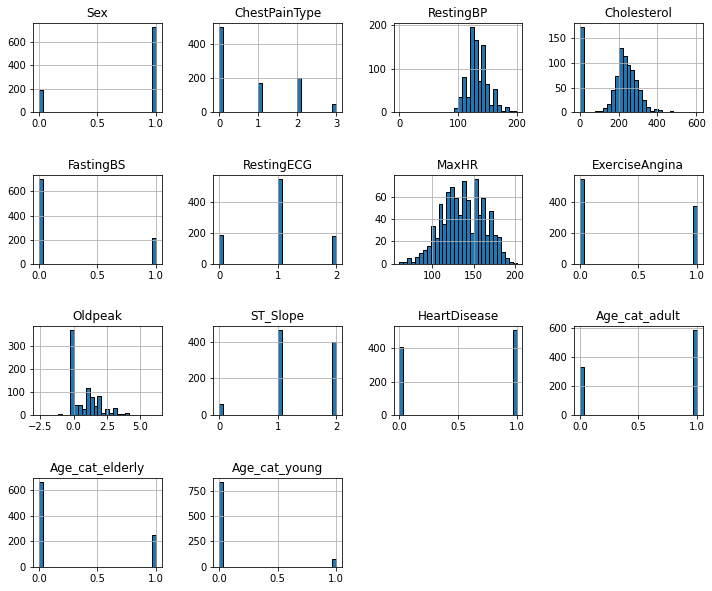

In [ ]:
data.hist(figsize=(12, 10), bins=30, edgecolor="black")
a = plt.subplots_adjust(hspace=0.7, wspace=0.4)

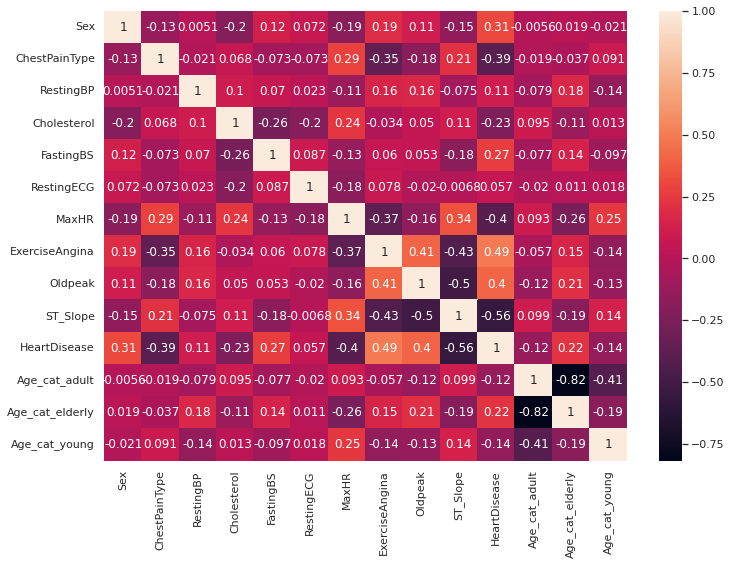

In [ ]:
#таблица корреляции
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(data.corr(), annot=True)

видим, что столбцы некоррелируют между собой

### 3.Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

In [ ]:
data.columns

Index(['Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease', 'Age_cat_adult', 'Age_cat_elderly', 'Age_cat_young'],
      dtype='object')

In [ ]:
X = data[['Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'Age_cat_adult', 'Age_cat_elderly', 'Age_cat_young']]
y = data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.Обучите дерево решений на обучающем множестве. Используйте следующие модели:


#### a) tree.DecisionTreeClassifier


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
model_tree = DecisionTreeClassifier(max_depth=5, random_state=123)

In [ ]:
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=123)

In [ ]:
model_tree.score(X_train, y_train)

0.896457765667575

In [ ]:
model_tree.score(X_test, y_test)

0.8586956521739131

#### b) ensemble.RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model_forest = RandomForestClassifier(max_depth=5, random_state=123)

In [ ]:
model_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=123)

In [ ]:
model_forest.score(X_train, y_train)

0.9005449591280654

In [ ]:
model_forest.score(X_test, y_test)

0.8858695652173914

### 5.Для тестового множества сделайте предсказание целевой переменной. Выведите метрики для каждой построенной модели с помощью metrics.classification_report.

In [ ]:
 from sklearn.metrics import classification_report

In [ ]:
# предсказания
pred_tree = model_tree.predict(X_test)
pred_forest = model_forest.predict(X_test)

In [ ]:
# метрики
print(classification_report(y_test, pred_tree))

              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84        77
         1.0       0.90      0.85      0.88       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



In [ ]:
print(classification_report(y_test, pred_forest))

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87        77
         1.0       0.91      0.89      0.90       107

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184



### 6.Выведите важность признаков, полученную после обучения модели из п. 4b в виде столбчатой диаграммы. Отсортируйте важность по убыванию.

In [ ]:
imp = pd.Series(model_forest.feature_importances_)


In [ ]:
imp.index = pd.Series(X_train.columns)
imp = imp.sort_values(ascending=False)
imp

ST_Slope           0.250354
ExerciseAngina     0.170223
ChestPainType      0.139951
Oldpeak            0.131713
MaxHR              0.091440
Cholesterol        0.091269
Sex                0.036168
RestingBP          0.030342
FastingBS          0.024332
Age_cat_elderly    0.013504
RestingECG         0.011602
Age_cat_adult      0.006467
Age_cat_young      0.002635
dtype: float64

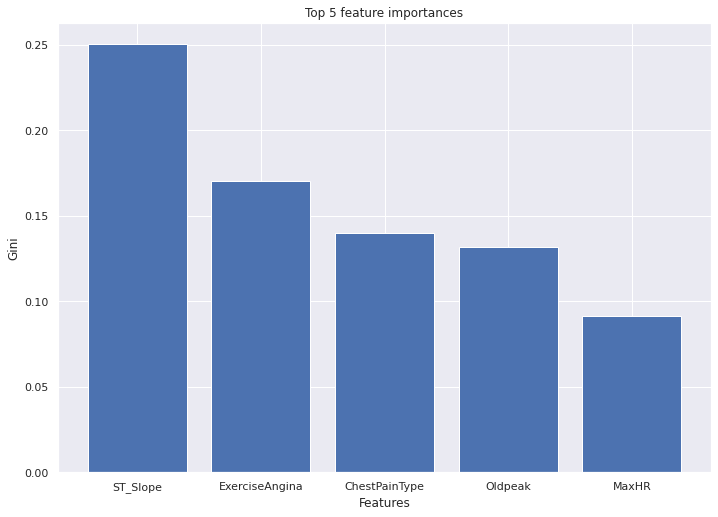

In [ ]:
plt.title('Top 5 feature importances')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar(imp.head().index, imp.head())
plt.show()

### 7.Обучите бэггинг над моделью из п. 4a. Используйте ensemble.BaggingClassifier.


In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
bagging = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=10,
                           max_samples=0.5,
                           max_features=0.5,
                           random_state=10)

In [ ]:
bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=0.5,
                  max_samples=0.5, random_state=10)

#### a)Повторите п. 5

In [ ]:
# предсказания
pred_bagging = bagging.predict(X_test)

In [ ]:
pred_bagging

array([0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.])

In [ ]:
# метрики
print(classification_report(y_test, pred_bagging))

              precision    recall  f1-score   support

         0.0       0.78      0.90      0.84        77
         1.0       0.92      0.82      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



### 8.Обучите стекинг трех моделей: из п. 4a, п. 4b и svm.LinearSVC. Используйте ensemble.StackingClassifier.


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeCV

In [ ]:
# Создаем стэккинг и обучаем его на наших данных

stacking = StackingClassifier(
    [
        ('DecisionTreeClassifier', model_tree),
        ('RandomForestClassifier', model_forest),
        ('LinearSVC', LinearSVC())
    ])

In [ ]:
stacking.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

StackingClassifier(estimators=[('DecisionTreeClassifier',
                                DecisionTreeClassifier(max_depth=5,
                                                       random_state=123)),
                               ('RandomForestClassifier',
                                RandomForestClassifier(max_depth=5,
                                                       random_state=123)),
                               ('LinearSVC', LinearSVC())])

#### a)Повторите п. 5

In [ ]:
# предсказания
pred_stacking= stacking.predict(X_test)

In [ ]:
# метрики
print(classification_report(y_test, pred_stacking))

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86        77
         1.0       0.90      0.89      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



### 9.Сформулируйте выводы по проделанной работе.
a) Сравните метрики построенных моделей.
b) Напишите свое мнение, какая модель наилучшая и почему.


ВЫВОДЫ:

обучили 4 модели: DecisionTreeClassifier, RandomForestClassifier, BaggingClassifier (над DecisionTreeClassifier) и StackingClaasifier (над DecisionTreeClassifier, RandomForestClassifier и LinearSVC).

Наилучшие метрики у RandomForestClassifier,